### 2.3.6 决策树集成
集成(ensemble)是合并多个机器学习模型来构建更强大模型的方法。在机器学习文献中有许多模型都属于这一类，但已证明有两种集成模型对大量分类和回归的数据集都是有效的，二者都以决策树为基础，分别是`随机森林(random forest)`和`梯度提升决策树(gradient boosted decision tree)`。

#### 2.3.6.1 随机森林
决策树的一个主要缺点在于经常对训练数据过拟合。随机森林是解决这个问题的一种方法。随机森林本质上是许多决策树的集合，其中每棵树都和其他树略有不同。随机森林背后的思想是，每棵树的预测可能都相对较好，但可能对部分数据过拟合。如果构造很多树，并且每棵树的预测都很好，但都以不同的方式过拟合，那么我们可以对这些树的结果取平均值来降低过拟合。既能减少过拟合又能保持树的预测能力，这可以在数学上严格证明。

为了实现这一策略，我们需要构造许多决策树。每棵树都应该对目标值做出可以接受的预测，还应该与其他树不同。随机森林的名字来自于将随机性添加到树的构造过程中，以确保每棵树都各不相同。

*随机森林中树的随机化方法有两种：一种是通过选择用于构造树的数据点，另一种是通过选择每次划分测试的特征。*

##### 构造随机森林
想要构造一个随机森林模型，你需要确定用于构造的树的个数。比如我们想要构造10棵树。这些树在构造时彼此完全独立，算法对每棵树进行不同的随机选择，以确保树和树之间是有区别的。想要构造一棵树，首先要对数据进行自助采样(bootstrap sample)。也就是说，从$n\_samples$个数据点中有放回地重复随机抽取一个样本，共抽取$n_samples$次。这样会创建一个与原数据集大小相同的数据集，但有些数据点会缺失（大约三分之一），有些会重复。

举例说明，比如我们想要创建列表$[a, b, c, d]$的自助采样。一种可能的自主采样是$[b, d, d, c]$，另一种可能的采样为$[d, a, d, a]$。

接下来，基于这个新创建的数据集来构造决策树。但是，要对我们在介绍决策树时描述的算法稍作修改。在每个结点处，算法随机选择特征的一个子集，并对其中一个特征寻找最佳测试，而不是对每个结点都寻找最佳测试。选择的特征个数由 max_features 参数来控制。每个结点中特征子集的选择是相互独立的，这样树的每个结点可以使用特征的不同子集来做出决策。

由于使用了自助采样，随机森林中构造每棵决策树的数据集都是略有不同的。由于每个结点的特征选择，每棵树中的每次划分都是基于特征的不同子集。这两种方法共同保证随机森林中所有树都不相同。

在这个过程中的一个关键参数是$max\_features$。如果我们设置$max\_features$等于特征的数量，那么每次划分都要考虑数据集的所有特征，在特征选择的过程中没有添加随机性（不过自助采样依然存在随机性）。如果设置$max\_features$等于1，那么在划分时将无法选择对哪个特征进行测试，只能对随机选择的某个特征搜索不同的阈值。因此，如果$max\_features$较大，那么随机森林中的树将会十分相似，利用最独特的特征可以轻松拟合数据。如果$max\_features$较小，那么随机森林中的树将会差异很大，为了很好地拟合数据，每棵树的深度都要很大。

想要利用随机森林进行预测，算法首先对森林中的每棵树进行预测。对于回归问题，我们可以对这些结果取平均值作为最终预测。对于分类问题，则用到了“软投票”（soft voting）策略。也就是说，每个算法做出“软”预测，给出每个可能的输出标签的概率。对所有树的预测概率取平均值，然后将概率最大的类别作为预测结果。

##### 分析随机森林
下面将由5棵树组成的随机森林应用到前面研究过的two_moons数据集上：


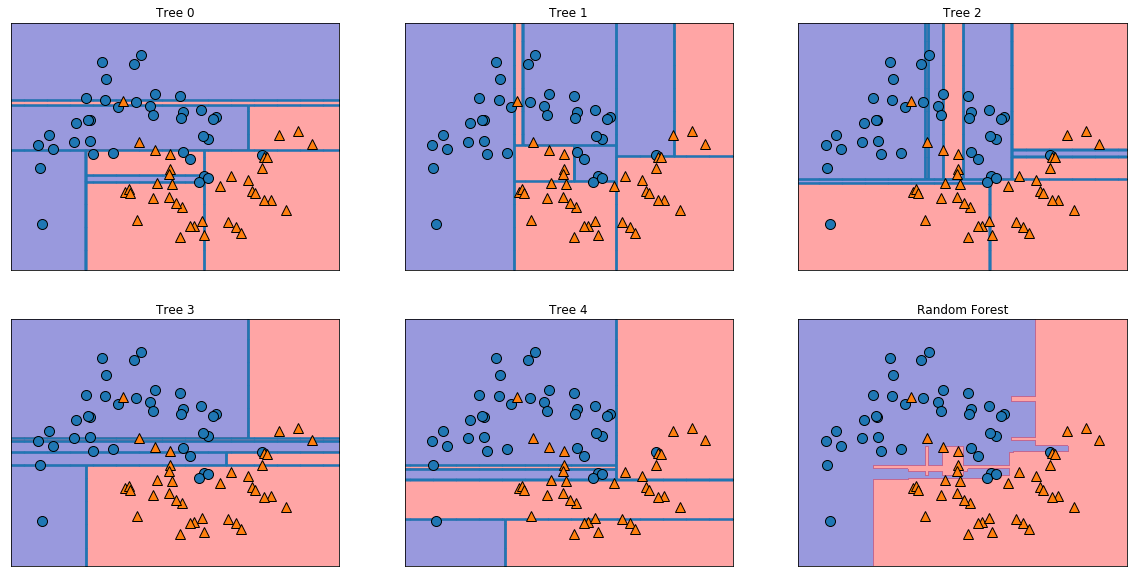

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import mglearn

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

# 作为随机森林的一部分，树被保存在estimator_属性中
# 我们将每棵树的决策边界可视化，也将整个森林的预测可视化
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.show()

5棵树学到的决策边界大不相同，每棵树都犯了一些错误，因为这里画出的一些训练点实际上并没有包含在这些树的训练集中，原因在于自助采样。

随机森林比单独每一棵树的过拟合都要小，给出的决策边界也更符合直觉。在任何实际应用中，我们会用到更多棵树（通常是几百或上千），从而得到更平滑的边界。

再举一个例子，我们将包含100棵树的随机森林应用在乳腺癌数据集上：

In [2]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
import matplotlib.pyplot as plt
import numpy as np
import mglearn

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


在没有调节任何参数的情况下，随机森林的精度为比线性模型或单棵决策树都要好。我们可以调节$max\_features$参数，或者像单棵决策树那样进行预剪枝。但是，随机森林的默认参数通常就已经可以给出很好的结果。

与决策树类似，随机森林也可以给出特征重要性，计算方法是将森林中所有树的特征重要性求和并取平均。一般来说，随机森林给出的特征重要性要比单棵树给出的更为可靠。

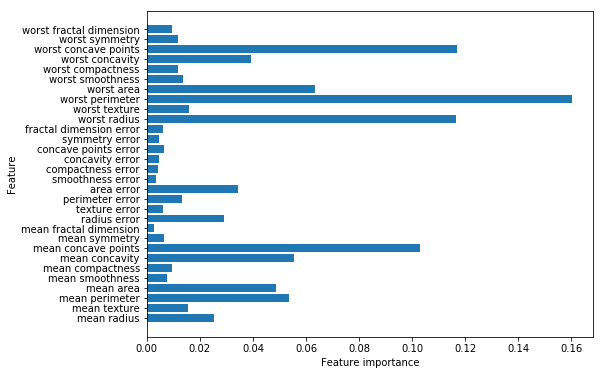

In [3]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), cancer.feature_names) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(forest)
plt.gcf().set_size_inches(8, 6)
plt.show()

与单棵树相比，随机森林中有更多特征的重要性不为零。与单棵决策树类似，随机森林也给了“worst radius”特征很大的重要性，但从总体来看，它实际上却选择“worst perimeter”作为信息量最大的特征。由于构造随机森林过程中的随机性，算法需要考虑多种可能的解释，结果就是随机森林比单棵树更能从总体把握数据的特征。

##### 优点、缺点和参数
用于回归和分类的随机森林是目前应用最广泛的机器学习方法之一。这种方法非常强大，通常不需要反复调节参数就可以给出很好的结果，也不需要对数据进行缩放。

从本质上看，随机森林拥有决策树的所有优点，同时弥补了决策树的一些缺陷。仍然使用决策树的一个原因是需要决策过程的紧凑表示。基本上不可能对几十棵甚至上百棵树做出详细解释，随机森林中树的深度往往比决策树还要大（因为用到了特征子集）。因此，如果你需要以可视化的方式向非专家总结预测过程，那么选择单棵决策树可能更好。

在大型数据集上构建随机森林比较费时间，可以通过$n\_jobs$参数来设置使用的内核个数，并行构建随机森林。设置$n\_jobs$大于内核个数是没有用的。设置$n\_jobs=-1$来使用所有内核。

随机森林本质上是随机的，设置不同的随机状态可以彻底改变构建的模型。森林中的树越多，它对随机状态选择的鲁棒性就越好。如果你希望结果可以重现，必须固定$random\_state$。

对于维度非常高的稀疏数据（比如文本数据），随机森林的表现往往不是很好。对于这种数据，使用线性模型可能更合适。即使是非常大的数据集，随机森林的表现通常也很好，训练过程很容易并行在功能强大的计算机的多个CPU内核上。不过，随机森林需要更大的内存，训练和预测的速度也比线性模型要慢。对一个应用来说，如果时间和内存很重要的话，那么换用线性模型可能更为明智。

需要调节的重要参数有$n\_estimators$和$max_features$，可能还包括预剪枝选项(如$max\_depth$)。$n\_estimators$总是越大越好。对更多的树取平均可以降低过拟合，从而得到鲁棒性更好的集成。不过收益是递减的，而且树越多需要的内存也越多，训练时间也越长。常用的经验法则就是“在你的时间 / 内存允许的情况下尽量多”。

$max\_features$决定每棵树的随机性大小，较小的$max\_features$可以降低过拟合。一般来说，好的经验就是使用默认值：对于分类，默认值是$max\_features=sqrt(n\_features)$；对于回归，默认值是$max\_features=n\_features$。增大$max\_features$或$max\_leaf\_nodes$有时也可以提高性能。它还可以大大降低用于训练和预测的时间和空间要求。

#### 2.3.6.2 梯度提升回归树
梯度提升回归树是另一种集成方法，通过合并多个决策树来构建一个更为强大的模型。虽然名字中含有“回归”，但这个模型既可以用于回归也可以用于分类。与随机森林方法不同，梯度提升采用连续的方式构造树，每棵树都试图纠正前一棵树的错误。默认情况下，梯度提升回归树中没有随机化，而是用到了强预剪枝。梯度提升树通常使用深度很小(1到5之间)的树，这样模型占用的内存更少，预测速度也更快。

梯度提升背后的主要思想是合并许多简单的模型(在这个语境中叫作弱学习器)，比如深度较小的树。每棵树只能对部分数据做出好的预测，因此，添加的树越来越多，可以不断迭代提高性能。

*梯度提升树经常是机器学习竞赛的优胜者，并且广泛应用于业界。与随机森林相比，它通常对参数设置更为敏感，但如果参数设置正确的话，模型精度更高。*

除了预剪枝与集成中树的数量之外，梯度提升的另一个重要参数是学习率$learning\_rate$，用于控制每棵树纠正前一棵树的错误的强度。较高的学习率意味着每棵树都可以做出较强的修正，这样模型更为复杂。通过增大$n\_estimators$来向集成中添加更多树，也可以增加模型复杂度，因为模型有更多机会纠正训练集上的错误。

下面是在乳腺癌数据集上应用`GradientBoostingClassifier`的示例。默认使用100棵树，最大深度是3，学习率为0.1：

In [4]:
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
import matplotlib.pyplot as plt
import numpy as np
import mglearn

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


由于训练集精度达到100%，所以很可能存在过拟合。为了降低过拟合，我们可以限制最大深度来加强预剪枝，也可以降低学习率：

In [5]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
print("GradientBoostingClassifier with `max_depth=1` >>>>>>>>>>")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)
print("\n\nGradientBoostingClassifier with `learning_rate=0.01` >>>>>>>>>>")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

GradientBoostingClassifier with `max_depth=1` >>>>>>>>>>
Accuracy on training set: 0.991
Accuracy on test set: 0.972


GradientBoostingClassifier with `learning_rate=0.01` >>>>>>>>>>
Accuracy on training set: 0.988
Accuracy on test set: 0.965


降低模型复杂度的两种方法都降低了训练集精度，这和预期相同。在这个例子中，减小树的最大深度显著提升了模型性能，而降低学习率仅稍稍提高了泛化性能。

对于其他基于决策树的模型，我们也可以将特征重要性可视化，以便更好地理解模型。由于我们用到了100棵树，所以即使所有树的深度都是1，查看所有树也是不现实的：

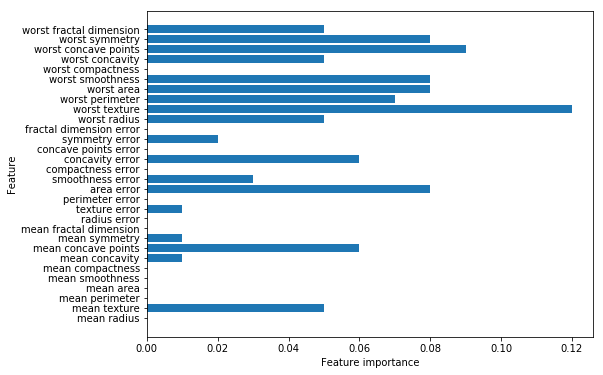

In [6]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)
plt.gcf().set_size_inches(8, 6)
plt.show()

梯度提升树的特征重要性与随机森林的特征重要性有些类似，不过梯度提升完全忽略了某些特征。

由于梯度提升和随机森林两种方法在类似的数据上表现得都很好，因此一种常用的方法就是先尝试随机森林，它的鲁棒性很好。如果随机森林效果很好，但预测时间太长，或者机器学习模型精度小数点后第二位的提高也很重要，那么切换成梯度提升通常会有用。

如果你想要将梯度提升应用在大规模问题上，可以研究一下`xgboost`包，在写作本书时，这个库在许多数据集上的速度都比`scikit-learn`对梯度提升的实现要快（有时调参也更简单）。

##### 优点、缺点和参数
梯度提升决策树是监督学习中最强大也最常用的模型之一。其主要缺点是需要仔细调参，而且训练时间可能会比较长。与其他基于树的模型类似，这一算法不需要对数据进行缩放就可以表现得很好，而且也适用于二元特征与连续特征同时存在的数据集。与其他基于树的模型相同，它也通常不适用于高维稀疏数据。

梯度提升树模型的主要参数包括树的数量$n\_estimators$和学习率$learning\_rate$，后者用于控制每棵树对前一棵树的错误的纠正强度。这两个参数高度相关，因为$learning\_rate$越低，就需要更多的树来构建具有相似复杂度的模型。随机森林的$n\_estimators$值总是越大越好，但梯度提升不同，增大$n\_estimators$会导致模型更加复杂，进而可能导致过拟合。通常的做法是根据时间和内存的预算选择合适的$n\_estimators$，然后对不同的$learning\_rate$进行遍历。

另一个重要参数是$max\_depth$或$max\_leaf\_nodes$，用于降低每棵树的复杂度。梯度提升模型的$max\_depth$通常都设置得很小，一般不超过5。